In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
train_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
val_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
test_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"

In [5]:
def zero_whites(x):
    _, h, w = x.shape
    
    # Check if any of the corner pixels or middle edge pixels are white
    corners_and_edges_white = torch.any(
        torch.cat([
            x[:, 0:1, 0:1],         # Top-left corner
            x[:, 0:1, w-1:],       # Top-right corner
            x[:, h-1:, 0:1],       # Bottom-left corner
            x[:, h-1:, w-1:],      # Bottom-right corner
            x[:, h//2:h//2+1, 0:1],  # Middle-left edge
            x[:, 0:1, w//2:w//2+1],  # Middle-top edge
            x[:, h-1:, w//2:w//2+1], # Middle-bottom edge
            x[:, h//2:h//2+1, w-1:]  # Middle-right edge
        ], dim=1) > 0.94
    )
    
    # Invert the image if any of the corners or middle edges are white
    if corners_and_edges_white:
        x = 1 - x
        
    return x


train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.Grayscale(),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Lambda(zero_whites),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and standard deviation
])

val_test_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(zero_whites),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and standard deviation
])


In [6]:
class FractureDataset(Dataset):
    def __init__(self, root_path, transform):
        self.root = root_path
        self.transform = transform
        self.classes = os.listdir(root_path)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = self.make_dataset()
        
    def make_dataset(self):
        samples = []
        for class_name in self.classes:
            class_path = os.path.join(self.root, class_name)
            class_idx = self.class_to_idx[class_name]
            for filename in os.listdir(class_path):
                sample_path = os.path.join(class_path, filename)
                samples.append((sample_path, class_idx))
        return samples
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        img = Image.open(image_path)
        if self.transform:  # Use self.transform
            img = self.transform(img)  # Use self.transform
        return img, label


In [7]:
train_dataset = FractureDataset(root_path=train_path, transform=train_transform)
val_dataset = FractureDataset(root_path=val_path, transform=val_test_transform)
test_dataset = FractureDataset(root_path=test_path, transform=val_test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

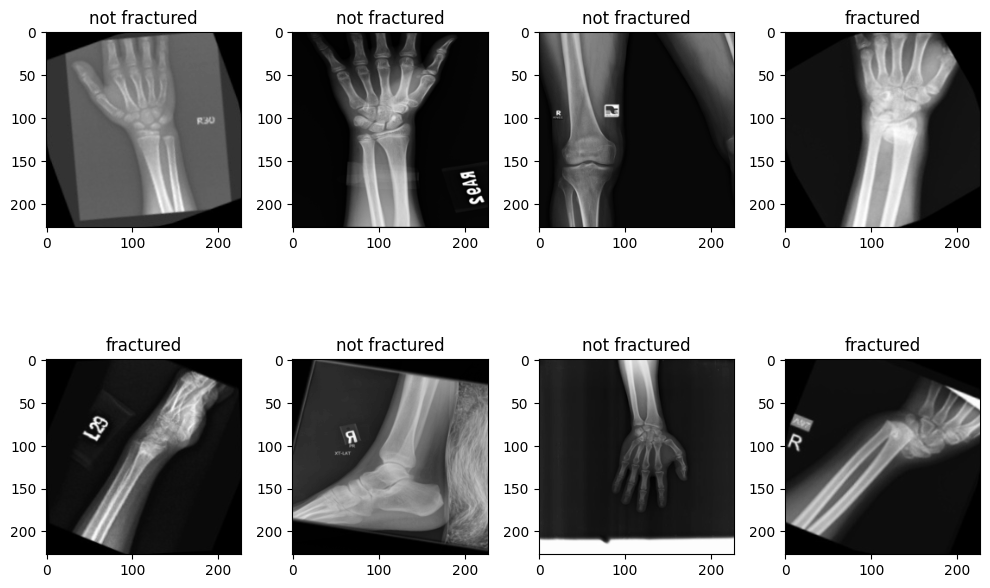

In [8]:
import matplotlib.pyplot as plt

# Assuming train_dataloader is your PyTorch DataLoader containing (images, labels) tuples

idx_to_cls = {
    0: "not fractured",
    1: "fractured"
}

fig, axs = plt.subplots(2, 4, figsize=(10, 7))

batch_size = 8  # Assuming batch size is 8
image_counter = 0

for batch_idx, (images, labels) in enumerate(test_dataloader):
    for img, label in zip(images, labels):
        class_name = idx_to_cls[label.item()]
        ax = axs[image_counter // 4, image_counter % 4]  # Selecting the correct subplot
        ax.set_title(class_name)
        ax.imshow(img.squeeze(), cmap='gray')  # Assuming the images are 2D grayscale
        image_counter += 1
        if image_counter >= batch_size:
            break
    if image_counter >= batch_size:
        break

plt.tight_layout()
plt.show()


In [9]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.sigmoid(out)
        return out
    



class BoneFractureV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d = nn.Conv2d(1, 1, 3)
        self.max_pool = nn.MaxPool2d(2)
        self.batch_norm = nn.BatchNorm2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(32768, 1024)
        self.output = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu(x)
        out = self.output(x) 
        return out

In [10]:
from torch.optim import SGD, Adam
from torch.nn import BCELoss
from torch.optim.lr_scheduler import StepLR



model = VGG16().to(device)
loss_fn = BCELoss()
optimizer = SGD(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [57]:
epochs = 25
model.to(device)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0
    
    train_correct = 0
    val_correct = 0
    
    train_total = 0
    val_total = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        logits = model(images)

        preds = torch.sigmoid(logits)

        binary_preds = (preds > 0.5).float()
        batch_correct = (binary_preds.squeeze() == labels).sum()
        
        train_correct += batch_correct
        
        train_total += labels.size(0)
        
        
        loss = loss_fn(preds.squeeze(), labels.float())
        total_train_loss += loss.item()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        
    scheduler.step()
       
    with torch.no_grad():
        model.eval()
        for batch_idx, (images, labels) in enumerate(val_dataloader):
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            preds = torch.sigmoid(logits)
            
            binary_preds = (preds > 0.5).float()
            
            batch_correct = (binary_preds.squeeze() == labels).sum()
            
            val_correct += batch_correct
            
            val_total += labels.size(0)
            
            loss = loss_fn(preds.squeeze(), labels.float())
            total_val_loss += loss.item()

            
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'#Epoch [{epoch+1}/{epochs}]')
    print(f"Avg train Loss: {avg_train_loss:.4f}")
    print(f'Avg val Loss: {avg_val_loss:.4f}')
    
    print('#Accuracy:')
    print(f"Train accuracy: {(train_correct / train_total * 100):.2f}%")
    print(f"Validation accuracy: {(val_correct / val_total * 100):.2f}%")

#Epoch [1/10]
Avg train Loss: 0.0017
Avg val Loss: 0.3898
#Accuracy:
Train accuracy: 99.96%
Validation accuracy: 98.67%
#Epoch [2/10]
Avg train Loss: 0.0015
Avg val Loss: 0.3878
#Accuracy:
Train accuracy: 99.97%
Validation accuracy: 98.79%
#Epoch [3/10]
Avg train Loss: 0.0014
Avg val Loss: 0.3935
#Accuracy:
Train accuracy: 99.96%
Validation accuracy: 98.67%
#Epoch [4/10]
Avg train Loss: 0.0016
Avg val Loss: 0.1829
#Accuracy:
Train accuracy: 99.98%
Validation accuracy: 98.31%
#Epoch [5/10]
Avg train Loss: 0.0011
Avg val Loss: 0.3921
#Accuracy:
Train accuracy: 100.00%
Validation accuracy: 98.79%
#Epoch [6/10]
Avg train Loss: 0.0011
Avg val Loss: 0.3864
#Accuracy:
Train accuracy: 99.99%
Validation accuracy: 99.03%
#Epoch [7/10]
Avg train Loss: 0.0013
Avg val Loss: 0.3897
#Accuracy:
Train accuracy: 99.98%
Validation accuracy: 98.91%
#Epoch [8/10]
Avg train Loss: 0.0013
Avg val Loss: 0.3912
#Accuracy:
Train accuracy: 99.98%
Validation accuracy: 98.91%
#Epoch [9/10]
Avg train Loss: 0.0013
Av

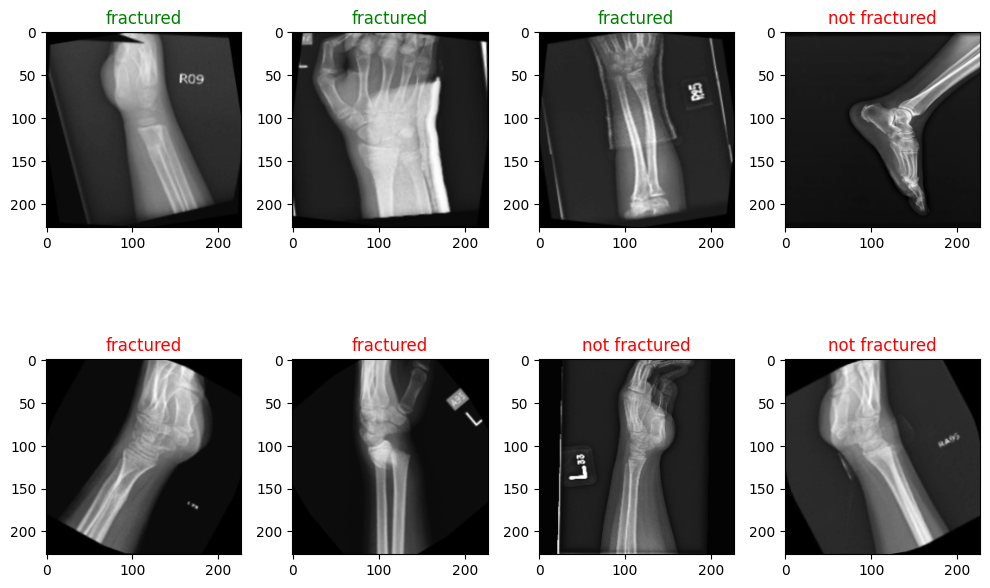

In [11]:
import matplotlib.pyplot as plt
model.to("cpu")

fig, axs = plt.subplots(2, 4, figsize=(10, 7))

batch_size = 8
image_counter = 0

for batch_idx, (images, labels) in enumerate(test_dataloader):
    for img, label in zip(images, labels):
        img, label = img.to("cpu"), label.to("cpu")
        logits = model(img.unsqueeze(0))
        preds = torch.sigmoid(logits)
        
        binary_pred = (preds > 0.5)
        color = "green" if binary_pred == label.item() else "red"

        class_name = idx_to_cls[label.item()]
        ax = axs[image_counter // 4, image_counter % 4]  # Selecting the correct subplot
        ax.set_title(class_name, color=color)
        ax.imshow(img.squeeze(), cmap='gray')  # Assuming the images are 2D grayscale
        image_counter += 1
        if image_counter >= batch_size:
            break
    if image_counter >= batch_size:
        break

plt.tight_layout()
plt.show()

In [12]:
correct = 0
total = 0
model.to(device)
with torch.no_grad():
    for img, label in test_dataloader:
        img, label = img.to(device), label.to(device)

        logits = model(img)

        preds = torch.sigmoid(logits)

        binary_preds = (preds > 0.5).float()

        batch_correct = (binary_preds.squeeze() == label).sum()

        correct += batch_correct

        total += label.size(0)
    print(correct / total * 100)

torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size([8, 1, 227, 227])
torch.Size([8])
torch.Size

In [13]:
#########################

In [22]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [23]:
from torch import nn
from torch.nn import Sequential

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

custom_classifier = Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 1)
)

model.fc = custom_classifier
model.to(device)
print("Done")

Done


In [24]:
def zero_whites(x):
    _, h, w = x.shape
    
    # Check if any of the corner pixels or middle edge pixels are white
    corners_and_edges_white = torch.any(
        torch.cat([
            x[:, 0:1, 0:1],         # Top-left corner
            x[:, 0:1, w-1:],       # Top-right corner
            x[:, h-1:, 0:1],       # Bottom-left corner
            x[:, h-1:, w-1:],      # Bottom-right corner
            x[:, h//2:h//2+1, 0:1],  # Middle-left edge
            x[:, 0:1, w//2:w//2+1],  # Middle-top edge
            x[:, h-1:, w//2:w//2+1], # Middle-bottom edge
            x[:, h//2:h//2+1, w-1:]  # Middle-right edge
        ], dim=1) > 0.94
    )
    
    # Invert the image if any of the corners or middle edges are white
    if corners_and_edges_white:
        x = 1 - x
        
    return x

def expand_dims_and_convert_to_rgb(img):
    # Resize the image to the desired dimensions (299x299 for Inception)
    resized_img = img.resize((299, 299))
    
    # Convert the image to numpy array
    img_arr = np.array(resized_img)
    
    # Check if the image is grayscale
    if len(img_arr.shape) == 2:  # Grayscale images have 2 dimensions
        # Convert grayscale to RGB by duplicating the image across 3 channels
        img_arr = np.stack((img_arr,) * 3, axis=-1)
        
    if img_arr.ndim == 3 and img_arr.shape[2] == 4:
        img_arr = img_arr[:, :, :3]
    
    img = Image.fromarray(img_arr)    
    
    return img



train_transform = transforms.Compose([
    transforms.Lambda(expand_dims_and_convert_to_rgb),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Lambda(zero_whites),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and standard deviation
])

val_test_transform = transforms.Compose([
    transforms.Lambda(expand_dims_and_convert_to_rgb),
    transforms.ToTensor(),
    transforms.Lambda(zero_whites),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and standard deviation
])

In [25]:
train_dataset = FractureDataset(root_path=train_path, transform=train_transform)
val_dataset = FractureDataset(root_path=val_path, transform=val_test_transform)
test_dataset = FractureDataset(root_path=test_path, transform=val_test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [29]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10



for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        logits = outputs.logits
        
        preds = torch.sigmoid(logits)

        loss = loss_fn(preds.squeeze(), labels.float())
        total_train_loss += loss.item()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

       
    with torch.no_grad():
        model.eval()
        for batch_idx, (images, labels) in enumerate(val_dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            logits = outputs
        
            preds = torch.sigmoid(logits)
            
            loss = loss_fn(preds.squeeze(), labels.float())
            total_val_loss += loss.item()


    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Avg train Loss: {avg_train_loss:.4f}')
    print(f'Epoch [{epoch+1}/{epochs}], Avg val Loss: {avg_val_loss:.4f}')

Epoch [1/5], Avg train Loss: 0.4676
Epoch [1/5], Avg val Loss: 0.4597
Epoch [2/5], Avg train Loss: 0.4611
Epoch [2/5], Avg val Loss: 0.3402
Epoch [3/5], Avg train Loss: 0.4768
Epoch [3/5], Avg val Loss: 0.3707
Epoch [4/5], Avg train Loss: 0.4598
Epoch [4/5], Avg val Loss: 0.3816


In [ ]:
correct = 0
total = 0
model.to(device)
with torch.no_grad():
    for img, label in test_dataloader:
        img, label = img.to(device), label.to(device)

        logits = model(img)

        preds = torch.sigmoid(logits)

        binary_preds = (preds > 0.5).float()

        batch_correct = (binary_preds.squeeze() == label).sum()

        correct += batch_correct

        total += label.size(0)
    print(correct / total * 100)